In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
db = 'chinook.db'

In [3]:
def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q,conn)

In [4]:
def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)

In [5]:
def show_tables():
    q = """SELECT
    name,
    type
    FROM sqlite_master
    WHERE type IN ("table","view");"""
    return run_query(q)
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [6]:
run_query("SELECT * FROM Genre LIMIT 10")

,genre_id,name
0,1,Rock
1,2,Jazz
2,3,Metal
3,4,Alternative & Punk
4,5,Rock And Roll
5,6,Blues
6,7,Latin
7,8,Reggae
8,9,Pop
9,10,Soundtrack


In [7]:
albums_for_purchasing = '''
WITH usa_tracks_sold AS
   (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
    WHERE c.country = "USA"
   )

SELECT
    g.name genre,
    count(uts.invoice_line_id) tracks_sold,
    cast(count(uts.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) from usa_tracks_sold
    ) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t on t.track_id = uts.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
'''

data = run_query(albums_for_purchasing)

In [8]:
#generate table

In [9]:
data.head(10)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


In [10]:
data.set_index("genre",drop=True,inplace=True)

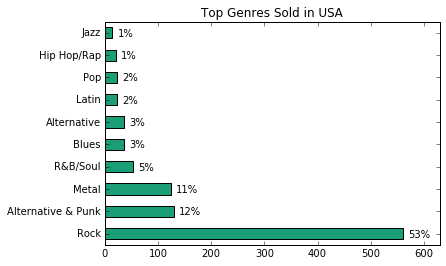

In [11]:
data["tracks_sold"].plot.barh(
    title = "Top Genres Sold in USA", colormap="Dark2",
    xlim=(0, 630))

plt.ylabel('')

for i, label in enumerate(list(data.index)):
    score = data.loc[label, "tracks_sold"]
    label = (data.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

Rock is by far the top selling genre but not in the list of potential albums to sell. Based purely on genre popularity and knowing nothing about the artists, we should clearly sell the punk album (12% of sales), but the question of which two out of the other three isnt so simple, and theres probably a better answer than going for the highest numbers since they're all low and so tightly bunched. For example, does a certain one of those genres sell for more than the others? If so it should probably get added. Based purely on numbers, it would be the blues and pop albums, along with Punk

In [12]:
employee_sales = '''SELECT
    e.first_name || " " || e.last_name employee_name,
    e.hire_date,
    SUM(i.total) total_sales_$
FROM employee e
INNER JOIN customer c ON c.support_rep_id = e.employee_id
INNER JOIN invoice i ON i.customer_id = c.customer_id

GROUP BY 1
ORDER BY 3 DESC
;
'''
data1 = run_query(employee_sales)

In [13]:
data1.head(10)

,employee_name,hire_date,total_sales_$
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


Steve Johnson has sold a lot more in a short space of time

In [14]:
data1.set_index("employee_name",drop=True,inplace=True)

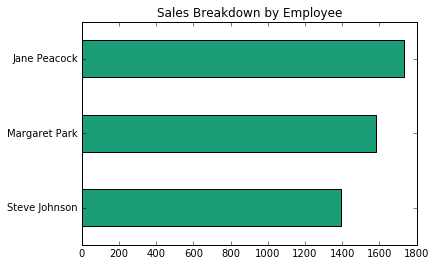

In [15]:
data1.sort_values("total_sales_$", inplace=True)
data1.plot.barh(
    legend=False,
    title='Sales Breakdown by Employee',
    colormap=plt.cm.Dark2
)
plt.ylabel('')
plt.show()

Margaret and Jane similar, Steve on track to outperform

In [16]:
sales_by_country_query = '''
WITH country_or_other AS
    (
     SELECT
        CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

sales_by_country = run_query(sales_by_country_query)

In [17]:
sales_by_country_no_other = sales_by_country[0:9]

In [18]:
sales_by_country_no_other

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000


In [19]:
sales_by_country

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


In [29]:
sales_by_country.set_index("country", drop=True, inplace=True)

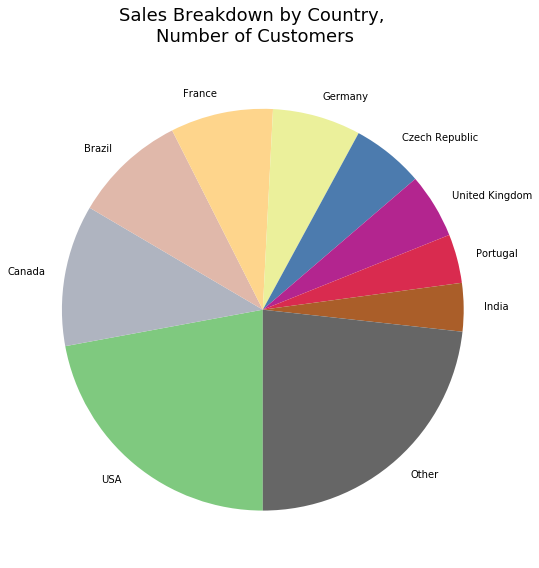

In [30]:
sales_breakdown = sales_by_country["total_sales"].copy().rename('')
plt.suptitle('Sales Breakdown by Country, \nNumber of Customers', fontsize=18)
sales_breakdown.plot.pie(
    figsize = (9,9),
    startangle=-90,
    counterclock=False,
    colormap=plt.cm.Accent,
    fontsize=10,
    wedgeprops={'linewidth':0}
    
)

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


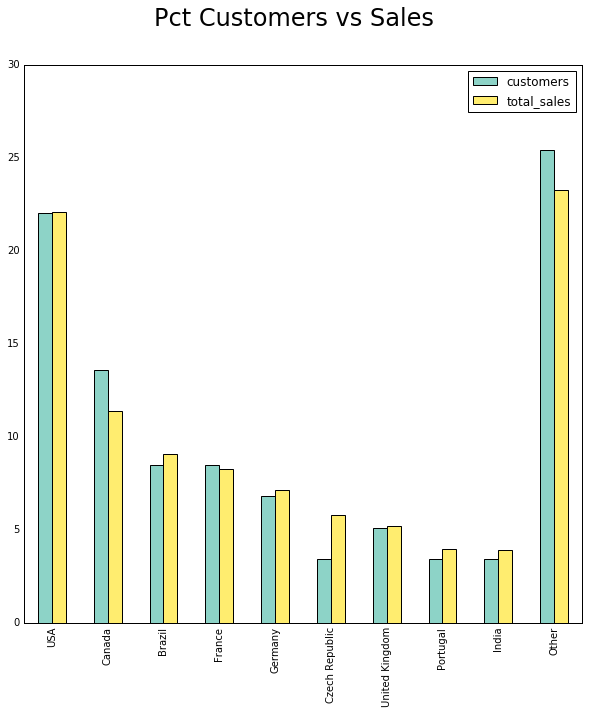

In [42]:
cols = ["customers","total_sales"]
customer_v_dollars = sales_by_country[cols]
customer_v_dollars.index.name = ''

for c in cols:
    customer_v_dollars[c] /= customer_v_dollars[c].sum() / 100
customer_v_dollars.plot.bar(
    figsize = (10,10),
    colormap=plt.cm.Set3)

plt.tick_params(top="off", right="off", left="off", bottom="off")
plt.suptitle("Pct Customers vs Sales", fontsize=24)


Looks like proportion of sales to customers in each country is pretty similar. Czech Republic a good ratio of sales to customers

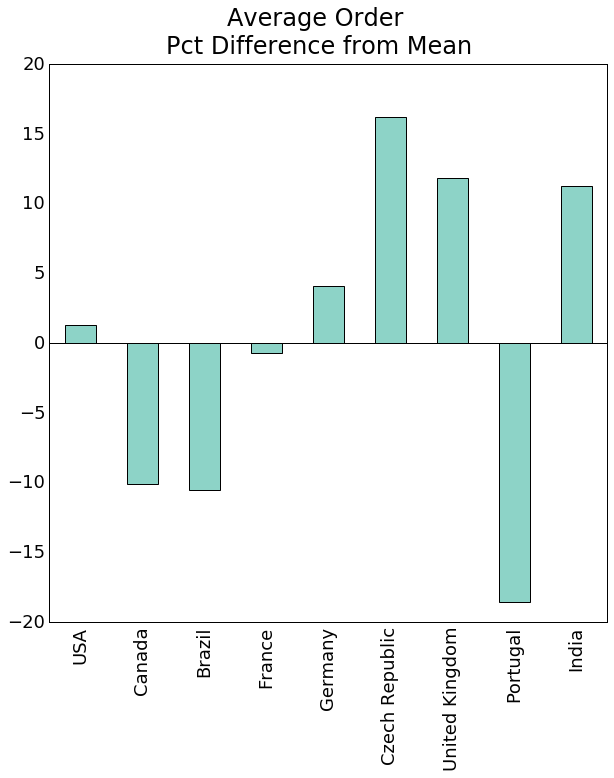

In [48]:
average_value = sales_by_country["average_order"].copy()
average_value.index.name = ''
diff_from_average = average_value * 100 / average_value.mean() - 100
diff_from_average.drop("Other", inplace = True)
plt.suptitle('Average Order \nPct Difference from Mean', fontsize=24)

diff_from_average.plot.bar(
    figsize = (10,10),
    colormap=plt.cm.Set3,
    fontsize=18
)
plt.tick_params(top="off", right="off", left="off", bottom="off")
plt.axhline(0, color='k')

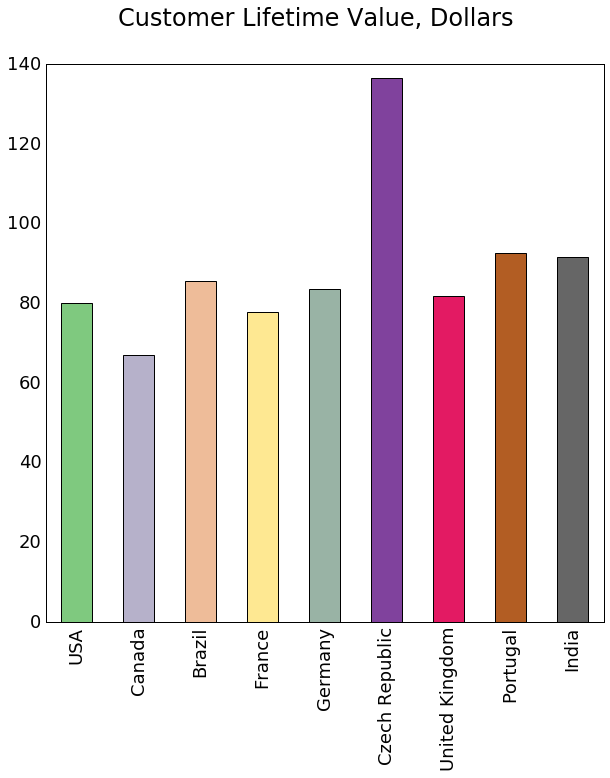

In [53]:
import numpy as np
life_value = sales_by_country["customer_lifetime_value"].copy()
life_value.index.name = ''
life_value.drop("Other", inplace = True)
plt.suptitle('Customer Lifetime Value, Dollars', fontsize=24)

life_value.plot.bar(
    figsize = (10,10),
    color = [plt.cm.Accent(i) for i in np.linspace(0, 1, life_value.shape[0])],
    fontsize=18
)
plt.tick_params(top="off", right="off", left="off", bottom="off")

Low level of data but looks like Czech Republic, UK and India are decent earners, but only barely in the case of the latter two

In [54]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


Nearly 20% album sales, 